Unit Cube Volumetric Growth
---
This notebook will implement basic unit cube growth following the schematic set out in DOI 10.1007/s10237-015-0723-8.  
Note, this growth is homogeneous so no residual stresses will accumulate, even without resetting the reference.

In [1]:
import dolfin
import numpy as np
import fenics_plotly
import matplotlib.pyplot as plt

In [2]:
dolfin.set_log_level(30)
fenics_plotly.set_renderer("iframe")
output_file = dolfin.XDMFFile('deformation.xdmf')
deg = 2
dolfin.parameters["form_compiler"]["quadrature_degree"]=deg
dolfin.parameters["form_compiler"]["representation"] = "uflacs"

# First, the mesh
mesh = dolfin.UnitCubeMesh(1,1,1)
original_mesh = dolfin.UnitCubeMesh(1,1,1)
original_traction_mesh = dolfin.UnitCubeMesh(1,1,1)

In [3]:
# I'm going to pre-define some functions that will be useful later, and keep things less cluttered
def calculate_reaction_force(Ftotal, dirichlet_bcs, x_dofs):
    
    """ Calculate reaction force on cube on left face. Negates it to give rxn on right face
    
    :Ftotal: weak form
    :dirichlet_bcs: list of dirichlet boundary conditions
    :x_dofs: degree of freedoms in x-direction from vector element
    
    return: scalar reaction force on right cube face in x-direction
    """
    
    b = dolfin.assemble(Ftotal)
    for boundary_condition_i in np.arange(np.shape(dirichlet_bcs)[0]-1):
        dirichlet_bcs[boundary_condition_i+1].apply(b)
    f_int_total = b.copy()
    rxn_force=0.0
    for kk in x_dofs:
        rxn_force += f_int_total[kk]
        
    return -1.0*rxn_force

def calculate_pk2_stress(W_passive, E_comp, lcs):
    
    """ Return 2nd Piola Kirchhoff stress in fiber direction.
    
    :W_passive: strain energy function defined in terms of local coordinates
    :E_comp: list, Green-Lagrange strain transformed into local coordinates
    :lcs: list, local coordinate system vectors
    
    return: scalar stress in fiber direction
    """
    
    f0 = lcs[0]
    s0 = lcs[1]
    n0 = lcs[2]
    
    Eff = E_comp[0]
    Efs = E_comp[1]
    Efn = E_comp[2]
    Esf = E_comp[3]
    Ess = E_comp[4]
    Esn = E_comp[5]
    Enf = E_comp[6]
    Ens = E_comp[7]
    Enn = E_comp[8]
    
    # doing this differentiation separately for each tensor component
    S_local = (dolfin.diff(W_passive,Eff)*dolfin.outer(f0,f0) + dolfin.diff(W_passive,Efs)*dolfin.outer(f0,s0) 
            + dolfin.diff(W_passive,Efn)*dolfin.outer(f0,n0,) + dolfin.diff(W_passive,Esf)*dolfin.outer(s0,f0) 
            + dolfin.diff(W_passive,Ess)*dolfin.outer(s0,s0) + dolfin.diff(W_passive,Esn)*dolfin.outer(s0,n0) 
            + dolfin.diff(W_passive,Enf)*dolfin.outer(n0,f0) + dolfin.diff(W_passive,Ens)*dolfin.outer(n0,s0) 
            + dolfin.diff(W_passive,Enn)*dolfin.outer(n0,n0))
    
    
    
    
    
    
    S_f = dolfin.inner(f0,S_local*f0)
    pk2_stress_fiber = dolfin.project(S_f,dolfin.FunctionSpace(mesh,"DG",1)).vector().get_local()[0] #homogeneous, just picking first value
    
    return pk2_stress_fiber



In [4]:
# Set up elements and spaces for the problem
Velem = dolfin.VectorElement("CG", mesh.ufl_cell(), 2, quad_scheme="default")

# For hydrostatic pressure (enforcing incompressibility)
Qelem = dolfin.FiniteElement("CG", mesh.ufl_cell(), 1, quad_scheme="default")

# Mixed element
W = dolfin.FunctionSpace(mesh, dolfin.MixedElement([Velem, Qelem]))
x_dofs = W.sub(0).sub(0).dofmap().dofs() # for calculating reaction force

# For the weak form
w = dolfin.Function(W)
dw = dolfin.TrialFunction(W)
wtest = dolfin.TestFunction(W)

du, dp = dolfin.TrialFunctions(W)
u, p = dolfin.split(w)
v, q = dolfin.TestFunctions(W)

In [5]:
# Let's create a local coordinate system for the cube. Could use vectors, but going to define them as would be seen for a ventricle
V_space = dolfin.FunctionSpace(mesh,Velem)

f0 = dolfin.Function(V_space) # coincident with x-axis
s0 = dolfin.Function(V_space) # coincident with y-axis
n0 = dolfin.Function(V_space) # coincident with z-axis

for i in np.arange(np.shape(f0.vector())[0]/3.0):
    f0.vector()[3*i] = 1.0
    s0.vector()[3*i+1] = 1.0
    n0.vector()[3*i+2] = 1.0

In [6]:
# Boundary conditions. Traction will be applied to right face
# Allowing uniform expansion in y and z for uniform motion due to incompressibility

# Set up classes for Dirichlet boundary conditions
class Left(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0]) < tol

class Lower(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[2]) < tol

class Fix(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return (dolfin.near(x[0],0.0,tol) and dolfin.near(x[1],0.0,tol) and dolfin.near(x[2],0.0,tol))
    
class Right(dolfin.SubDomain):
    def inside(self, x, on_boundary):
        tol = 1E-14
        return on_boundary and abs(x[0] - 1.0) < tol

facetboundaries = dolfin.MeshFunction('size_t', mesh, mesh.topology().dim()-1)
facetboundaries.set_all(0)

N = dolfin.FacetNormal(mesh)
ds = dolfin.ds(subdomain_data = facetboundaries)
dx = dolfin.dx(mesh,metadata = {"integration_order":2})

left  = Left()
lower = Lower()
fix   = Fix()
right = Right()

left.mark(facetboundaries, 1)
lower.mark(facetboundaries, 2)
fix.mark(facetboundaries, 3)
right.mark(facetboundaries, 4)

# Constrain left face in x
bc_left  = dolfin.DirichletBC(W.sub(0).sub(0), dolfin.Constant((0.0)), facetboundaries, 1)
# Constrain lower face in z
bc_lower = dolfin.DirichletBC(W.sub(0).sub(2), dolfin.Constant((0.0)), facetboundaries, 2)
# Fixing point at origin to prevent rigid body translation
bc_fix   = dolfin.DirichletBC(W.sub(0), dolfin.Constant((0.0, 0.0, 0.0)), fix, method="pointwise")
dirichlet_bcs = [bc_left, bc_lower, bc_fix]

Now to define kinematic quantities. This is where we will define the deformation gradient and its multiplicative split. The elastic part will be used for the strain energy function. Following the schematic from figure 1 from the above paper, $F_{e}$ will be the same as $F$ during transient loading (the cardiac cycle) because the reference configuration is being reset after each growth step.  

First, let's define the growth deformation gradient. We will do this by defining tensors $M_{1}$, $M_{2}$, $M_{3}$ using the local coordinate system such that:  

$$M_{1} = \theta_{f} (f_{0}\otimes f_{0})$$  
$$M_{2} = \theta_{s} (s_{0}\otimes s_{0})$$  
$$M_{3} = \theta_{n} (n_{0}\otimes n_{0})$$  

and $\theta_{\alpha}$ governs the amount of growth in each direction, usually a function of some deviation of a stimulus from a homeostatic set point. You can think of $\theta_{f}$ governing eccentric growth, and $\theta_{s}, \theta_{n}$ as governing concentric growth.

In [7]:
tensorFS = dolfin.TensorFunctionSpace(mesh,"DG",1)
M1 = dolfin.outer(f0,f0)
M2 = dolfin.outer(s0,s0)
M3 = dolfin.outer(n0,n0)

# Using a DG1 space for the thetas. I suppose this depends on how you expect your stimulus to behave within/across elements
theta_FS = dolfin.FunctionSpace(mesh,"DG",1)
theta_f = dolfin.Function(theta_FS)
theta_s = dolfin.Function(theta_FS)
theta_n = dolfin.Function(theta_FS)

# Initialize thetas to one, so that Fg is initialized to be the identity tensor
theta_f.vector()[:] = 1.0
theta_s.vector()[:] = 1.0
theta_n.vector()[:] = 1.0
    
F_g = theta_f*M1 + theta_s*M2 + theta_n*M3

In [8]:
# Now define F and Fe
dim = u.ufl_domain().geometric_dimension()
I = dolfin.Identity(dim)
F = I + dolfin.grad(u)
F_e = F*dolfin.inv(F_g) # Now, if F_g is updated, for a given F, F_e can be calculated
J = dolfin.det(F_e) # We want the elastic deformation to be volume preserving, but not the growth from F_g. This may have implications for growth 
# without resetting the reference configuration, haven't thought much about that.

# Green-Lagrangian Strain tensor based on F_e
E = 0.5*(F_e.T*F_e - I)


In [9]:
#Now let's set up the weak form
W_incompressible = -p*(J - 1.0)

# Guccione law

# Get strain in terms of local coordinates
Eff = dolfin.variable(dolfin.inner(f0, E*f0))
Ess = dolfin.variable(dolfin.inner(s0, E*s0))
Enn = dolfin.variable(dolfin.inner(n0, E*n0))
Efs = dolfin.variable(dolfin.inner(f0, E*s0))
Efn = dolfin.variable(dolfin.inner(f0, E*n0))
Ens = dolfin.variable(dolfin.inner(n0, E*s0))
Esf = dolfin.variable(dolfin.inner(s0, E*f0))
Esn = dolfin.variable(dolfin.inner(s0, E*n0))
Enf = dolfin.variable(dolfin.inner(n0, E*f0))

lcs = [f0, s0, n0]
E_comp = [Eff, Efs, Efn, Esf, Ess, Esn, Enf, Ens, Enn]

# material parameters
c   = 0.26
bf  = 2.0
bx  = 5.58
bfx = 1.627

Q = bf*Eff**2.0 + bx*(Ess**2.0 + Enn**2.0 + Ens**2.0 + Esn**2.0) + bfx*(Efs**2.0 + Esf**2.0 + Efn**2.0 + Enf**2.0)
W_passive = (c/2.0)*(dolfin.exp(Q) - 1.0)

traction = dolfin.Expression(("traction"), traction = 0.0, degree = 0)

F_passive = dolfin.derivative(W_passive, w, wtest)*dx
F_incompressible = dolfin.derivative(W_incompressible, w, wtest)*dx
F_traction = dolfin.inner(traction*N, v)*ds(4,domain=mesh)

Ftotal = F_passive + F_incompressible - F_traction

Jac_passive_body = dolfin.derivative(F_passive, w, dw)
Jac_incompressible = dolfin.derivative(F_incompressible, w, dw)
Jac_traction = dolfin.derivative(F_traction, w, dw)

Jac_total = Jac_passive_body + Jac_incompressible  

In [10]:
# Let's first apply a traction to the cube and record the reaction force. We will apply the same traction later to the grown cube and compare reaction forces
pk2_stress_fiber = np.zeros(23)
rxn_force_history = np.zeros(23)
counter = 0

# Solving before traction increase
dolfin.solve(Ftotal == 0, w, bcs=dirichlet_bcs, J=Jac_total)
output_file.write(w.sub(0),counter)
rxn_force_history[counter] = calculate_reaction_force(Ftotal, dirichlet_bcs, x_dofs)
pk2_stress_fiber[counter] = calculate_pk2_stress(W_passive, E_comp, lcs)
counter += 1

for i in np.arange(10):
    traction.traction += 0.1
    dolfin.solve(Ftotal == 0, w, bcs=dirichlet_bcs, J=Jac_total)
    output_file.write(w.sub(0),counter)
    rxn_force_history[counter] = calculate_reaction_force(Ftotal, dirichlet_bcs, x_dofs)
    pk2_stress_fiber[counter] = calculate_pk2_stress(W_passive, E_comp, lcs)
    counter += 1
    
u, p = dolfin.split(w)
u_projected = dolfin.project(u,dolfin.VectorFunctionSpace(mesh,"CG",1))
dolfin.ALE.move(original_traction_mesh,u_projected)
    
# Reset traction to 0, re-apply right dirichlet bc
traction.traction = 0.0
dolfin.solve(Ftotal == 0, w, bcs=dirichlet_bcs, J=Jac_total)
output_file.write(w.sub(0),counter)
rxn_force_history[counter] = calculate_reaction_force(Ftotal, dirichlet_bcs, x_dofs)
pk2_stress_fiber[counter] = calculate_pk2_stress(W_passive, E_comp, lcs)
counter += 1

In [11]:
#----------------- Growth -----------------
# Now, calculate thetas based on deviation of stimulus, which will update F_g. Then solve for the unloaded configuration.
# Arbitrarily choosing to grow in the cross-fiber directions.

# Again for simplicity, I'm going to just increase the thetas. In a study, these would come from some growth function that you 
# will come up with.
theta_s.vector()[:] = 1.1
theta_n.vector()[:] = 1.1
# IMPORTANT NOTE: Doing something like
# theta_s += 0.1
# Does not work. It creates a new object theta_s that F_g is not pointing to. F_g will not be updated appropriately.
# In the past, I've calculated new theta values using a temporary function, and then using the assign method to appropriately update theta|


In [12]:

# Solve the traction free weak form. Since thetas have increased and F_g is no longer identity, and we are at the reference where F = I, F_e would give a 
# state of compression. This solving step will find the deformation that gets us back to nearly unstressed (should be stress free since this is a homegeneous 
# deformation).
dolfin.solve(Ftotal == 0, w, bcs = dirichlet_bcs, J = Jac_total)
output_file.write(w.sub(0),counter)
pk2_stress_fiber[counter] = calculate_pk2_stress(W_passive, E_comp, lcs)
rxn_force_history[counter] = calculate_reaction_force(Ftotal, dirichlet_bcs, x_dofs)
counter += 1

In [13]:
# Reset the reference configuration by moving nodes according to the deformation solution we just obtained
u, p = dolfin.split(w)
dolfin.ALE.move(mesh, dolfin.project(u, dolfin.VectorFunctionSpace(mesh, 'CG', 1)))

# Reset F_g to identity by resetting the thetas to 1
theta_s.vector()[:] = 1.0
theta_n.vector()[:] = 1.0

In [14]:
fig = fenics_plotly.plot(mesh, color='red',opacity=0.25,show=False)
fig.add_plot(fenics_plotly.plot(original_mesh,color='blue',opacity=0.25,show=False))

In [15]:
fig.show()

The original reference configuration is shown in blue, and the grown configuration shown in red. Using ALE.move sets this as the new mesh, and will relieve any residual stresses.

In [16]:
# Apply traction to grown mesh
for j in np.arange(10):
    traction.traction += 0.1
    dolfin.solve(Ftotal == 0, w, bcs=dirichlet_bcs, J=Jac_total)
    output_file.write(w.sub(0),counter)
    rxn_force_history[counter] = calculate_reaction_force(Ftotal, dirichlet_bcs, x_dofs)
    pk2_stress_fiber[counter] = calculate_pk2_stress(W_passive, E_comp, lcs)
    counter += 1


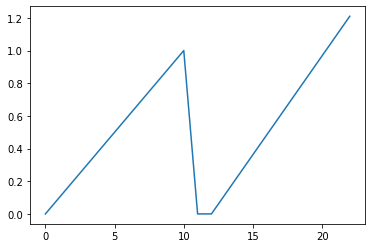

In [17]:
plt.plot(rxn_force_history)
plt.show()
# Let's compare
fig = fenics_plotly.plot(original_traction_mesh,color='blue',opacity=0.25,show=False)
u,p = dolfin.split(w)
u_p = dolfin.project(u,dolfin.VectorFunctionSpace(mesh,"CG",1))
dolfin.ALE.move(mesh,u_p)
fig.add_plot(fenics_plotly.plot(mesh,color='red',opacity=0.25,show=False))

In [18]:
fig.show()

Original (blue) and grown mesh (red) when tractions are applied. Specified tractions are per area, so the deformation in the x-direction is the same. However, it takes more force because of the increased area due to growth (seen in the above plots).

In [19]:
output_file.close()